## Defining Global Variables



In [ ]:
device = 'cuda'

TLDR_CSV_PATH = '/content/drive/MyDrive/tldr-all-summaries.csv'
GPT_SUMMARIES_PATH = '/content/drive/MyDrive/llama2-13b_100.json'
tldrs = ['TLDR', 'TL;DR', 'TL:DR', 'TL: DR', 'TL; DR', 'TL DR', 'TL, DR', 'TL,DR']

## TLDR Extraction

<ul>
  <li> We first split the post over "TLDR", and divide in into two sections: "before TLDR" and "after TLDR". The following TLDR formats were considered:
  
  `['TLDR', 'TL;DR', 'TL:DR', 'TL: DR', 'TL; DR', 'TL DR', 'TL, DR', 'TL,DR']`

  The part before TLDR is assumed to be the post and the part after is the TLDR summary.

  <li> As an additional filtering step, we remove all those (post, tldr) pairs that have length of tldr > 0.1 * length of the post.
  
</ul>

In [ ]:
import csv

pairs = []

with open(TLDR_CSV_PATH, 'r') as fin:
  reader = csv.DictReader(fin)
  tldr_found = None

  for row in reader:
    text = row['selftext']

    for tldr in tldrs:
      if tldr in text:
        tldr_found = tldr
        break

    if not tldr_found:
      continue

    tldr_split = text.split(tldr_found)

    if len(tldr_split) != 2:
      continue

    post, tldr = tldr_split

    if len(post) == 0:
      continue

    if len(tldr) / len(post) > 0.1:
      continue

    pairs.append([post, tldr])

## Loading GPT summaries

We use also use a prompt-based GPT summarizer as an alternative to TLDR summaries.

In [ ]:
import json

with open(GPT_SUMMARIES_PATH, 'r') as fin:
  content = json.loads(fin.read())

## Creating the Entailment Model

We use the `roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli` model from Huggingface, which was trained on the SNLI dataset.

It labels pairs of texts (premise, hypothesis) into one of these three classes

<ol>
<li> "entailment"
<li> "neutral"
<li> "contradiction"
</ol>

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

hg_model_hub_name = "ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli"

tokenizer = AutoTokenizer.from_pretrained(hg_model_hub_name)
model = AutoModelForSequenceClassification.from_pretrained(hg_model_hub_name)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of the model checkpoint at ynie/roberta-large-snli_mnli_fever_anli_R1_R2_R3-nli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS 

# Compute Entailment Subroutine

The `compute_entailment` subroutine computes the entailment scores of pairs of sentences (premise, hypothesis), given the tokenizer and the model.

In [ ]:
import torch

def compute_entailment(premise, hypothesis, tokenizer, model, max_length=256):

    tokenized_input_seq_pair = tokenizer.encode_plus(premise, hypothesis,
                                                     max_length=max_length,
                                                     return_token_type_ids=True, truncation=True)

    input_ids = torch.Tensor(tokenized_input_seq_pair['input_ids']).long().unsqueeze(0).to(device)

    token_type_ids = torch.Tensor(tokenized_input_seq_pair['token_type_ids']).long().unsqueeze(0).to(device)
    attention_mask = torch.Tensor(tokenized_input_seq_pair['attention_mask']).long().unsqueeze(0).to(device)

    outputs = model(input_ids,
                    attention_mask=attention_mask,
                    token_type_ids=token_type_ids,
                    labels=None)

    predicted_probability = torch.softmax(outputs[0], dim=1)[0].tolist()  # batch_size only one

    return predicted_probability[0]

In [ ]:
import pysbd
seg = pysbd.Segmenter(language="en", clean=False)

## Negative sampling

We generate negative samples: The posts are paired with any random summary (execpt the one that corresponds to the post) from the corpus. The difference in entailment scores over original (positive) samples and opposite (negative) samples will give use a fair idea about the distribution of examples.

In [ ]:
import random

def generate_opposite_pairs(pairs):
  opp_pairs = []

  for pair in pairs:

    _, random_tldr = random.choice(pairs)

    while random_tldr == pair[1]:
      _, random_tldr = random.choice(pairs)

    # Negative sampling
    opp_pairs.append([pair[0], random_tldr])

  return opp_pairs

## Get Entailment Scores Subroutine

The `get_entailment_scores` subroutine will iterate over pairs summaries of each post matched with each sentence from the post and compute the entailment scores over these pairs.

Note that the premise of every example will be the summary of the whole post, while the hypothesis will be an individual sentence from the post. This is done to deal with the strict limit of 256 input tokens in Roberta SNLI model.

In [ ]:
import numpy as np

def get_entailment_scores(pairs):
  entailments = []

  i = 0

  for post, summary in pairs[:100]:
    i += 1

    sentences = seg.segment(post)

    for sentence in sentences:
      score = compute_entailment(summary, sentence, tokenizer, model)
      entailments.append(score)

  return entailments

## Generating Entailment Scores and Percentiles


We generate entailment scores over positive and negative summaries in both TLDR and GPT summarized datasets. We also generate percentile scores of entailment scores in all the sets (positive TLDR, negative TLDR, positive GPT, and negative GPT) to get a sense of the distribution.

In [ ]:
percentiles = np.arange(0, 110, 10)

In [ ]:
import numpy as np

tldr_entailments = get_entailment_scores(pairs)

tldr_percentile_values = np.percentile(tldr_entailments, percentiles)

print(np.mean(tldr_entailments))

0.04980334163125933


In [ ]:
opp_pairs = generate_opposite_pairs(pairs)

In [ ]:
import numpy as np

tldr_opp_entailments = get_entailment_scores(opp_pairs)

tldr_opp_percentile_values = np.percentile(tldr_opp_entailments, percentiles)

print(np.mean(tldr_opp_entailments))

0.016867593710402407


## TLDR scores:

Mean entailment of positive pairs = 4.98 %

Mean entailment of negative pairs = 1.68 %

In [ ]:
pairs = [(post, summary) for post, summary in zip(content['selftext'].values(), content['doc_summ'].values())]

In [ ]:
import numpy as np

gpt_entailments = get_entailment_scores(pairs)

gpt_percentile_values = np.percentile(gpt_entailments, percentiles)

print(np.mean(gpt_entailments))

0.06702755333792636


In [ ]:
opp_pairs = generate_opposite_pairs(pairs)

In [ ]:
import numpy as np

gpt_opp_entailments = get_entailment_scores(opp_pairs)

gpt_opp_percentile_values = np.percentile(gpt_opp_entailments, percentiles)

print(np.mean(gpt_opp_entailments))

0.010512935983669078


## GPT scores:

Mean entailment of positive pairs = 6.70 %

Mean entailment of negative pairs = 1.05 %

## Percentile Plots

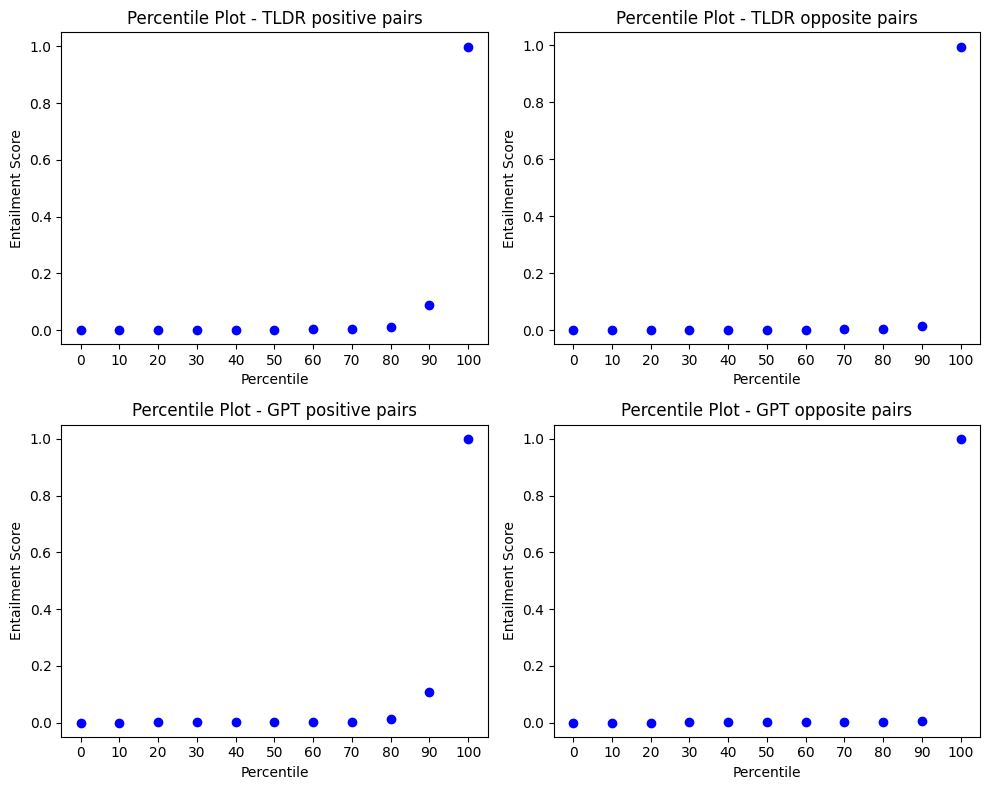

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Percentile Plots
axes[0, 0].plot(percentiles, tldr_percentile_values, marker='o', linestyle='None', color='b')
axes[0, 0].set_title('Percentile Plot - TLDR positive pairs')
axes[0, 0].set_xlabel('Percentile')
axes[0, 0].set_ylabel('Entailment Score')
axes[0, 0].set_xticks(percentiles)

axes[0, 1].plot(percentiles, tldr_opp_percentile_values, marker='o', linestyle='None', color='b')
axes[0, 1].set_title('Percentile Plot - TLDR opposite pairs')
axes[0, 1].set_xlabel('Percentile')
axes[0, 1].set_ylabel('Entailment Score')
axes[0, 1].set_xticks(percentiles)

axes[1, 0].plot(percentiles, gpt_percentile_values, marker='o', linestyle='None', color='b')
axes[1, 0].set_title('Percentile Plot - GPT positive pairs')
axes[1, 0].set_xlabel('Percentile')
axes[1, 0].set_ylabel('Entailment Score')
axes[1, 0].set_xticks(percentiles)

axes[1, 1].plot(percentiles, gpt_opp_percentile_values, marker='o', linestyle='None', color='b')
axes[1, 1].set_title('Percentile Plot - GPT opposite pairs')
axes[1, 1].set_xlabel('Percentile')
axes[1, 1].set_ylabel('Entailment Score')
axes[1, 1].set_xticks(percentiles)

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


## Results

These results show a siginficant difference between positive and negative sets in both TLDR and GPT datasets, while there is little difference between the entailment scores of TLDR and GPT datasets for both positive and negative sets.